# Customer classification with MATLAB 

Suppose that a financial services company wants to build a tool to classify customers as potential credit takers from an available pool of profiles. The quality of information obtained can be used to support decision making for conceding (or not) credit to a particular customer. Data-driven customer classification would be advantageous to accelerate credit analysis processes and also keep the default rate low.

This mini-project reports the deployment of some _Machine Learning_ algorithms to classify different customer profiles. First, let's load the data.

In [ ]:
% Read dataset file and convert into a table
data = readtable('./data/crx.data','Filetype', 'text');

Checking the loaded data is always the best practice.

In [227]:
summary(data)


Variables:

    Var1: 690x1 cell array of character vectors

    Var2: 690x1 double

        Values:

            Min             13.75  
            Median          28.46  
            Max             80.25  
            NumMissing      12     

    Var3: 690x1 double

        Values:

            Min            0  
            Median      2.75  
            Max           28  

    Var4: 690x1 cell array of character vectors

    Var5: 690x1 cell array of character vectors

    Var6: 690x1 cell array of character vectors

    Var7: 690x1 cell array of character vectors

    Var8: 690x1 double

        Values:

            Min            0  
            Median         1  
            Max         28.5  

    Var9: 690x1 cell array of character vectors

    Var10: 690x1 cell array of character vectors

    Var11: 690x1 double

        Values:

            Min           0   
            Median        0   
            Max          67   

    Var12: 690x1 cell array of character vectors

 

There are 690 customer profiles. For each profile, there are 15 features including 6 with numeric values and 9 categorical attributes. The dataset of profiles was provided as a raw data file with the features' names undisclosed to protect the source’s interest in the details.

## Data pre-processing

There are some missing values that we have to care about. 

In [248]:
% Remove missing values
data = rmmissing(data);

Let's create a logical array to track categorical features and spot them in further steps.

In [249]:
% Logical array keeping track of categorical attributes
names = data.Properties.VariableNames;
[nrows, ncols] = size(data);
category = false(1,ncols);
for i = 1:ncols
    if isa(data.(names{i}),'cell') || isa(data.(names{i}),'nominal')
        category(i) = true;     
    end
end
catPred = category(1:end-1);

Now we can convert those categorical attributes into numerical.

In [250]:
% Convert categorical values to numerical
for i = 1:ncols
    if isa(data.(names{i}),'cell') || isa(data.(names{i}),'nominal')
        [GN, ~, data.(names{i})] = unique(data.(names{i}));    
    end
end

Before continue, we need to separate the labels from the attributes.

In [251]:
% Set the random number seed to make the results repeatable 
rng('default');

% Segregate the data into response and predictors
y = data.Var16; % Response
disp('Credit Approval')
tabulate(y)

Credit Approval
  Value    Count   Percent
      1      299     44.89%
      2      367     55.11%


In [252]:
X = table2array(data(:,1:end-1)); % Predictor matrix

The next step is to create the _Test_ and _Training_ subsets in a 70:30 proportion.

Data division into training and test sets is common in the field of machine learning. The reason is simple: if you try to test the model with data you've learned (and since the aim is to predict using unknown data) you get something unreal.

In [253]:
% Hold 30% of the data, selected randomly, for test
cv = cvpartition(height(data),'holdout',0.30);

In [254]:
% Training set
Xtrain = X(training(cv),:);
ytrain = y(training(cv),:);
% Test set
Xtest = X(test(cv),:);
ytest = y(test(cv),:);

In [255]:
disp('Training Set')
tabulate(ytrain)
disp('Test Set')
tabulate(ytest)

Training Set
  Value    Count   Percent
      1      218     46.68%
      2      249     53.32%
Test Set
  Value    Count   Percent
      1       81     40.70%
      2      118     59.30%


As we can see, the profiles are divided into 47% to 53% between the two classes for the _Training_ subset and 41% and 59% for the _Test_ subset.

## K-Nearest Neighbors

In this algorithm, the nearest k (k = 1,2,3,…) instances are calculated to the test instance. To determine the class label, a single model is built on this set of k nearest neighbors. The majority class among the k neighbors is identified as the corresponding label.

A good characteristic of the k-nearest neighbor approach to classification is that it can be used for practically any type of data, as long as distances can be quantified between instances by using a distance function.

Next, we train this type of classifier, make some predictions, and print the _Confusion Matrix_.

In [256]:
%% Nearest Neighbors

% Train the classifier
knn = ClassificationKNN.fit(Xtrain,ytrain,'Distance','seuclidean');

% Make a prediction for the test set
y_knn = knn.predict(Xtest);

% Compute the confusion matrix
C_knn = confusionmat(ytest,y_knn);

% Examine the confusion matrix for each class as a percentage of the true class
C_knn = bsxfun(@rdivide,C_knn,sum(C_knn,2)) * 100



C_knn =

   72.8395   27.1605
   16.1017   83.8983



## Fuzzy K-Nearest Neighbors

This algorithm is an enhanced k-nearest Neighbors’ version. It builds on a class membership learning scheme which gives each training instance a range of memberships defining its variable membership in each class. After the learning process, the final classification is carried out in a similar way to the K-Nearest Neighbors’ algorithm but each neighbor uses its membership array for the class assignment rule instead of tacitly accept one class as in the crisp version. For an overlapping class pattern on data, this can decrease the misclassification rate.

This time we predefine the number of neighbors (_k_), normalize the features, train the model, and perform some predictions. In the end, we print the _Confusion Matrix_.

In [262]:
%% Fuzzy Nearest Neighbors

% Number of neighbors
k_values = 4;

% Normalize Predictors
XXtrain = minmaxnorm(Xtrain,0,1);
XXtest = minmaxnorm(Xtest,0,1);

% Classify using Fuzzy Nearest Neighbors
[y_fknn,memberships, numhits] = fknn(XXtrain, ytrain, XXtest, ytest, k_values, 0, 'true');

% Compute the confusion matrix
C_fknn = confusionmat(ytest,y_fknn);

% Examine the confusion matrix for each class as a percentage of the true class
C_fknn = bsxfun(@rdivide,C_fknn,sum(C_fknn,2)) * 100


C_fknn =

   82.7160   17.2840
   15.2542   84.7458



## Similarity Measure

The main idea of this algorithm is to use an ideal vector for each class and compute similarity from the dataset’s instances to these ideal vectors (one for each class). Instances’ vectors are assigned to the class of the ideal vector with the highest similarity to them. The comparison can be made with similarities of the generalized Łukasiewicz equation.

The algorithm quickly learns the classification task and can solve problems that are not linearly separable. It also explains swimmingly how and why the data is classified, all based on the principle of similarity.

First, we define the hyperparameters of the similarity measure, then normalize the features, compute the ideal vectors for each class, and finally perform classification using the similarity measure. The result is again in the form of a _Confusion Matrix_.

In [266]:
%% Similarity Measure

% Parameters for p, m and similarity measure 
param = [3.1,2.75,1];

% Normalize Predictors
XXtrain = minmaxnorm(Xtrain,0,1);
XXtest = minmaxnorm(Xtest,0,1);

% Compute ideal vectors for each class
ideals = idealvectors([XXtrain,ytrain], param);

% Classify data using Lukasiewicz similarity measure
[y_sim, Simil] = classifier(XXtest, ideals, param);

% Compute the confusion matrix
C_sim = confusionmat(ytest,y_sim);

% Examine the confusion matrix for each class as a percentage of the true class
C_sim = bsxfun(@rdivide,C_sim,sum(C_sim,2)) * 100


C_sim =

   87.6543   12.3457
   23.7288   76.2712



## Logistic Regression

Logistic regression is commonly employed to estimate the likelihood that an instance belongs to a certain class. If the predicted probability is greater than 50 percent, the model predicts that the instance is in that class, otherwise it predicts that it does not. It's therefore a binary classifier.

It works just like a linear regression model but instead of explicitly outputting the outcome as the result of linear regression, a logistic regression model computes a weighted sum of the input features (plus a bias term) and outputs the logistic of this result., i.e., the predicted probability.

As previously, we train the classifier, make some predictions, and print the _Confusion Matrix_.

In [267]:
%% Logistic Regression

% Train the classifier
glm = GeneralizedLinearModel.fit(Xtrain,double(ytrain)-1,'linear','Distribution','binomial','link','logit','CategoricalVars',catPred);

% Make a prediction for the test set
y_glm = glm.predict(Xtest);
y_glm = round(y_glm) + 1;

% Compute the confusion matrix
C_glm = confusionmat(ytest,y_glm);

% Examine the confusion matrix for each class as a percentage of the true class
C_glm = bsxfun(@rdivide,C_glm,sum(C_glm,2)) * 100

> In glmfit (line 338)
In GeneralizedLinearModel/fitter (line 668)
In classreg.regr/FitObject/doFit (line 94)
In GeneralizedLinearModel.fit (line 982)
> In classreg.regr/CompactTermsRegression/checkDesignRank (line 35)
In GeneralizedLinearModel.fit (line 1001)

C_glm =

   82.7160   17.2840
   15.2542   84.7458



## Decision Tree

The decision tree is one of the most insightful classification methods. It partitions the input space hierarchically until they enter a subspace with a class name. We can imagine the data instance entering the tree from the root to be labeled.

A decision tree is like a rooted, directed flowchart-like diagram – each inner node is a partitioning decision and each leaf node is mapped to a prediction of a class name. Every inner node is programmed by dividing the domain by one (or more) attributes of the data. The data instance is sent to one of the leaf nodes based on a splitting rule. Rule checking and forwarding are repeated until a leaf node is reached.

The workflow is no different: we train the classifier, make some predictions, and print the _Confusion Matrix_.

In [268]:
%% Decision Trees

% Train the classifier
t = ClassificationTree.fit(Xtrain,ytrain,'CategoricalPredictors',catPred);

% Make a prediction for the test set
Y_t = t.predict(Xtest);

% Compute the confusion matrix
C_t = confusionmat(ytest,Y_t);

% Examine the confusion matrix for each class as a percentage of the true class
C_t = bsxfun(@rdivide,C_t,sum(C_t,2)) * 100


C_t =

   85.1852   14.8148
   15.2542   84.7458



## Discriminant Analysis

The use of linear discriminants is an alternative way to perform classification tasks, which specifically try to construct directions in the feature space where the different classes are better segregated. 

In the discriminant approach, the main idea is to evaluate the directions of the data where instances are segregated as well as possible. Iteratively the subspace of the lower dimension is created.

In many ways, discriminant analysis has similarities with multiple regression analysis. The main difference between these two approaches is that regression analysis is concerned with a continuous dependent variable while in the discriminant analysis there must be a discrete dependent variable.

Again, we train the classifier, make some predictions, and print the _Confusion Matrix_.

In [269]:
%% Discriminant Analysis

% Train the classifier
da = ClassificationDiscriminant.fit(Xtrain,ytrain,'discrimType','diaglinear');

% Make a prediction for the test set
y_da = da.predict(Xtest);

% Compute the confusion matrix
C_da = confusionmat(ytest,y_da);

% Examine the confusion matrix for each class as a percentage of the true class
C_da = bsxfun(@rdivide,C_da,sum(C_da,2)) * 100


C_da =

   85.1852   14.8148
   19.4915   80.5085



## Model comparison

After the run of the above models it showed that best result with regards to F-score came
from the Decision Tree followed by the Logistic Regression. Below are the results:

In [295]:
%% Compare Results
% F-score = 2*TP /(2*TP + FP + FN)

Fscore_knn = 2*C_knn(1)/(2*C_knn(1)+C_knn(2)+C_knn(3))
Fscore_fknn = 2*C_fknn(1)/(2*C_fknn(1)+C_fknn(2)+C_fknn(3))
Fscore_sim = 2*C_sim(1)/(2*C_sim(1)+C_sim(2)+C_sim(3))
Fscore_glm = 2*C_glm(1)/(2*C_glm(1)+C_glm(2)+C_glm(3))
Fscore_t = 2*C_t(1)/(2*C_t(1)+C_t(2)+C_t(3))
Fscore_da = 2*C_da(1)/(2*C_da(1)+C_da(2)+C_da(3))


Fscore_knn =

    0.7710


Fscore_fknn =

    0.8356


Fscore_sim =

    0.8293


Fscore_glm =

    0.8356


Fscore_t =

    0.8500


Fscore_da =

    0.8324



The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall. The F-score is the preferred measure of performance specially when classes are unbalanced.

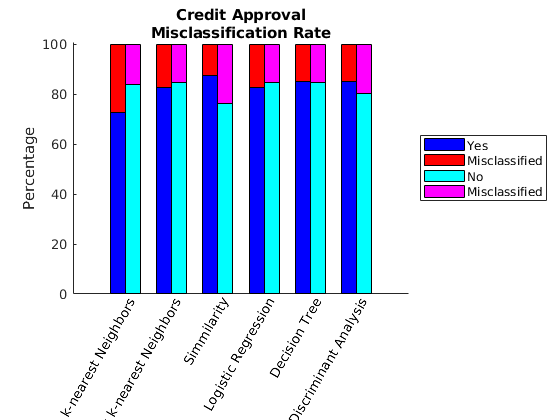

In [299]:
Cmat = [C_knn C_fknn C_sim C_glm C_t C_da];
labels = {'k-nearest Neighbors', 'Fuzzy k-nearest Neighbors','Simmilarity', 'Logistic Regression', 'Decision Tree', 'Discriminant Analysis'};

comparisonPlot( Cmat, labels )

From the figure above we can check that **Decision Tree** was the best method in terms of F-score and also got the best equilibrium between elements of the _Confusion Matrix_, i.e., the number of False Negatives and False Positives are equivalent (approximately 15 for each). 

Analyzing this information in the context of the financial domain means that 15 “good” customer profiles would be discarded as “not worthy” which may result in a loss of opportunity to profit by issuing them some kind of credit. On the other hand, the same number of False Positives was obtained, which means that some form of credit would have been granted to “bad” customers who may default resulting in losses for the financial institution).

## Conclusion

This mini-project reports the deployment of six methods of classification based on _Machine Learning_ algorithms to segment customer profiles into classes. From the six methods, two are not so popular besides one of them, Similarity Measure, being user friendly in terms of deployment and communication of results (in lay’s words).

Surprisingly, one of the most popular methods, i.e., K-Nearest Neighbors did not perform well in comparison with the others and this may due to the characteristic of the dataset. Along with the F-score performance, it was considered the equilibrium between the elements of the _Confusion Matrix_ which would bring an advantageous aspect if the domain of the classification task is considered in the analysis.